In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# constants and hyperparameters
TEST_PERC = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 20
DROPOUT_RATE = 0.2
LR = 0.001
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1.0e-8
DECAY = 0.0
VAL_PERC = 0.1

In [3]:
def generate_random_index_list(index_range, list_size):
    random.seed()
    index_list = []
    while(len(index_list)<list_size):
        index = random.randint(0,index_range)
        if((index in index_list)==False):
            index_list.append(index)
    return index_list         


In [4]:
if(os.path.isdir(os.getcwd()+'/dataset/processed') == False):
    species = pd.read_csv('class_names.csv').values.tolist()
    species.insert(0,['Alfafa'])
    i = 0
    os.makedirs(os.getcwd()+'/dataset/processed', exist_ok=True)
    os.makedirs(os.getcwd()+'/dataset/processed/training', exist_ok=True)
    os.makedirs(os.getcwd()+'/dataset/processed/testing', exist_ok=True)
    
    for dirname, _, filenames in os.walk(os.getcwd()+'/dataset/resized'):
        cur_specie = species[i][0]
        train_class_dir = os.getcwd()+'/dataset/processed/training/'+cur_specie
        test_class_dir = os.getcwd()+'/dataset/processed/testing/'+cur_specie
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        rand_indices = generate_random_index_list(len(filenames),int(len(filenames)*TEST_PERC))
        
        img_count = 1
        for filename in filenames:
            image = Image.open(os.path.join(dirname, filename))
            img_width, img_height = image.size
            if(img_width == img_height):
                image = image.resize((256,256))
            elif(img_width > img_height):
                image = image.resize((img_width, 256)).crop((0,0,256,256))
            else:
                image = image.resize((256, img_height)).crop((0,0,256,256))
            if(img_count in rand_indices):
                image.save(test_class_dir+'/'+cur_specie+str(img_count)+'.png')
            else:
                image.save(train_class_dir+'/'+cur_specie+str(img_count)+'.png')
            img_count += 1
        if(dirname != os.getcwd()+'/dataset/resized'):
            i += 1

In [5]:
def loadDataset(path):
    data = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            image = Image.open(os.path.join(dirname, filename))
            data.append([pd.array(image.getdata()),dirname])
    return pd.DataFrame(data)
            
    

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(os.getcwd()+'/dataset/processed/training',
                                             validation_split = VAL_PERC,
                                             subset = "training",
                                             seed = 123,
                                             batch_size = BATCH_SIZE)
val_dataset = image_dataset_from_directory(os.getcwd()+'/dataset/processed/training', 
                                             validation_split = VAL_PERC,
                                             subset = "validation",
                                             seed = 123,
                                             batch_size = BATCH_SIZE)

Found 14889 files belonging to 35 classes.
Using 13401 files for training.
Found 14889 files belonging to 35 classes.
Using 1488 files for validation.


In [7]:
test_dataset = image_dataset_from_directory(os.getcwd()+'/dataset/processed/testing',
                                            batch_size=BATCH_SIZE)

Found 1637 files belonging to 35 classes.


In [16]:
class_names = train_dataset.class_names
test_class_names = test_dataset.class_names
print(class_names==test_class_names)

True


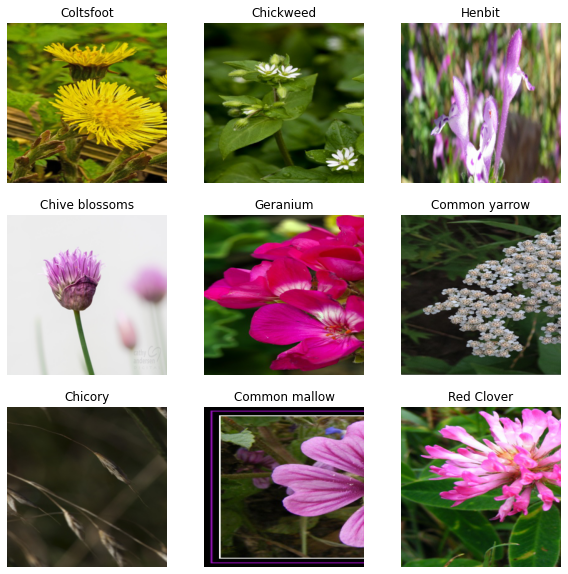

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.numpy())
    print(labels_batch.numpy())
    break

[[[[172. 155. 145.]
   [173. 156. 146.]
   [174. 156. 145.]
   ...
   [127.  88. 205.]
   [129.  91. 208.]
   [130.  93. 209.]]

  [[174. 156. 142.]
   [175. 156. 141.]
   [173. 156. 136.]
   ...
   [126.  87. 201.]
   [129.  90. 206.]
   [131.  93. 208.]]

  [[173. 154. 129.]
   [171. 153. 128.]
   [167. 151. 124.]
   ...
   [125.  84. 195.]
   [128.  88. 199.]
   [131.  91. 202.]]

  ...

  [[ 59.  49.  39.]
   [ 59.  49.  40.]
   [ 60.  50.  40.]
   ...
   [ 71.  57.  40.]
   [ 73.  58.  41.]
   [ 75.  60.  43.]]

  [[ 53.  43.  33.]
   [ 53.  43.  33.]
   [ 54.  44.  34.]
   ...
   [ 66.  53.  36.]
   [ 68.  55.  38.]
   [ 69.  56.  39.]]

  [[ 53.  43.  33.]
   [ 52.  42.  32.]
   [ 51.  41.  31.]
   ...
   [ 62.  50.  33.]
   [ 62.  50.  33.]
   [ 62.  50.  33.]]]


 [[[117. 127.  36.]
   [119. 128.  45.]
   [120. 129.  49.]
   ...
   [ 25.  20.   8.]
   [ 22.  20.  14.]
   [ 23.  21.  19.]]

  [[100. 105.  53.]
   [115. 123.  64.]
   [131. 141.  69.]
   ...
   [ 19.  23.   8.]
 

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
model_name = 'model_cnn'

history_file = os.path.join(model_name, f'history_{model_name}.csv')
logdir = os.path.join(model_name, 'log')
ckpts = os.path.join(model_name, 'ckpts')
os.makedirs(logdir, exist_ok=True)
os.makedirs(ckpts, exist_ok=True)

In [13]:
normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val_dataset = val_dataset.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9843138


In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(256,256,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

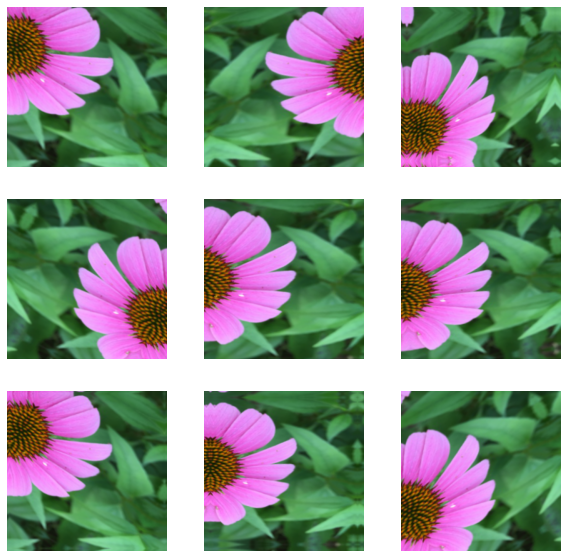

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
# build model
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
      
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(512, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(2*num_classes, activation='relu'),
    layers.Dense(num_classes)
])

In [18]:
from tensorflow.keras import optimizers, losses, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# set optimizer
opt = optimizers.Adam(learning_rate=LR,
    beta_1=BETA1,
    beta_2=BETA2,
    epsilon=EPSILON,
    decay=DECAY)

In [19]:
# set loss and metrics
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy']

In [20]:
# compile model: optimization method, training criterion and metrics
model.compile(
  optimizer=opt,
  loss=loss,
  metrics=metrics
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)       

In [21]:
# process input arguments
#parser = argparse.ArgumentParser()
#parser.add_argument('--model_name', 
#                    type=str,
#                    default='model_lstm', 
#                    help='--model_name=<model1|model2|...>')
#args = vars(parser.parse_args())
model_name	= 'model_cnn'

#print(f'\nModel type: {model_name}')

history_file = os.path.join(model_name, f'history_{model_name}.csv')
logdir = os.path.join(model_name, 'log')
ckpts = os.path.join(model_name, 'ckpts')
os.makedirs(logdir, exist_ok=True)
os.makedirs(ckpts, exist_ok=True)

In [22]:
# early stop, save best checkpoint
filepath = ckpts + '/weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5'
callbacks_list = [
  EarlyStopping(
    monitor='accuracy',
    patience=10),
  ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1),
  TensorBoard(
    log_dir=logdir),
    ]

In [23]:
# train model
history = model.fit(train_dataset,
  epochs=NUM_EPOCHS,
  batch_size=BATCH_SIZE,
  validation_data=val_dataset,
  callbacks=callbacks_list,
  verbose=1)

Epoch 1/20
419/419 [==============================] - ETA: 0s - loss: 3.2952 - accuracy: 0.0760
Epoch 1: val_accuracy improved from -inf to 0.11089, saving model to model_cnn\ckpts\weights-improvement-01-0.1109.hdf5
419/419 [==============================] - 261s 612ms/step - loss: 3.2952 - accuracy: 0.0760 - val_loss: 3.1002 - val_accuracy: 0.1109
Epoch 2/20
418/419 [============================>.] - ETA: 0s - loss: 2.9639 - accuracy: 0.1540
Epoch 2: val_accuracy improved from 0.11089 to 0.18145, saving model to model_cnn\ckpts\weights-improvement-02-0.1815.hdf5
419/419 [==============================] - 283s 662ms/step - loss: 2.9632 - accuracy: 0.1542 - val_loss: 2.7517 - val_accuracy: 0.1815
Epoch 3/20
418/419 [============================>.] - ETA: 0s - loss: 2.5028 - accuracy: 0.2574
Epoch 3: val_accuracy improved from 0.18145 to 0.32527, saving model to model_cnn\ckpts\weights-improvement-03-0.3253.hdf5
419/419 [==============================] - 279s 655ms/step - loss: 2.5022 - 

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


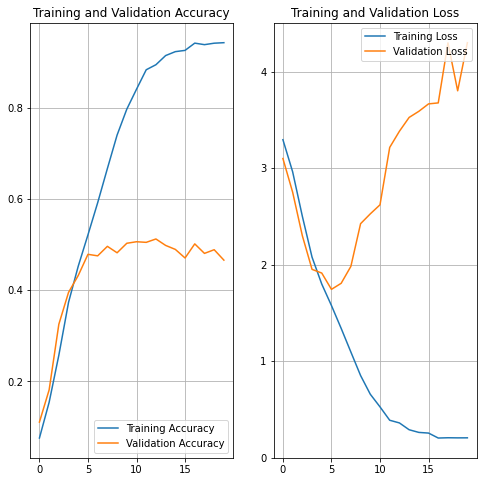

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
history_df = pd.DataFrame(history.history)
with open(history_file, mode='w') as f:
	history_df.to_csv(f)
    

In [27]:
model.save(os.path.join(model_name)+'/model')

INFO:tensorflow:Assets written to: model_cnn/model\assets


INFO:tensorflow:Assets written to: model_cnn/model\assets


In [28]:
evaluation_history = model.evaluate(test_dataset)

52/52 [==============================] - 34s 528ms/step - loss: 4.2087 - accuracy: 0.4820


In [29]:
print(evaluation_history)

[4.208736419677734, 0.48197922110557556]


In [30]:
'''img_path = os.getcwd()+'/dataset/processed/testing/Chicory/Chicory254.png'
img = tf.keras.utils.load_img(img_path)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch'''

y_pred = np.zeros(1637, dtype=int)
y_actual = np.zeros(1637, dtype=int)
confusion_matrix = np.zeros((num_classes,num_classes),dtype=int)
i = 0
j = 0
for dirname, _, filenames in os.walk(os.getcwd()+'/dataset/processed/testing/'):
    for filename in filenames:
        img = tf.keras.utils.load_img(os.path.join(dirname,filename))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        predictions = model.predict(img_array, verbose=0)
        score = tf.nn.softmax(predictions[0])
        y_actual[j] = i
        y_pred[j] = np.argmax(score)
        j += 1
        confusion_matrix[i][np.argmax(score)]+=1
    if(dirname != os.getcwd()+'/dataset/processed/testing/'):
        i += 1

'''print(type(test_dataset))

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)'''

'print(type(test_dataset))\n\npredictions = model.predict(img_array)\nscore = tf.nn.softmax(predictions[0])\n\nprint(\n    "This image most likely belongs to {} with a {:.2f} percent confidence."\n    .format(class_names[np.argmax(score)], 100 * np.max(score))\n)'

<AxesSubplot:>

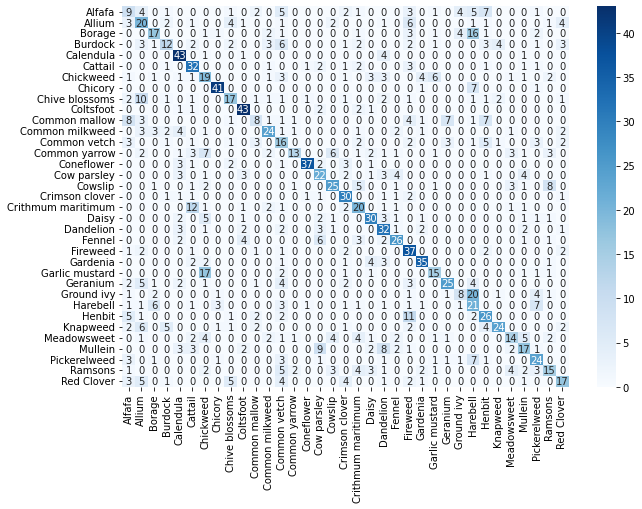

In [36]:
import seaborn as sb
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize = (10,7))
sb.heatmap(df_cm, annot=True, cmap="Blues")

In [31]:
np.savetxt(os.getcwd()+'/'+model_name+'/confusion_matrix.csv', confusion_matrix, delimiter=',')